In [61]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from IPython.display import display, HTML
import warnings
# warnings.filterwarnings('ignore')

In [62]:
df=pd.read_csv('data_10000.csv')
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,link
0,The Hunger Games,Suzanne Collins,English,4.33,"7,971,601","196,977",Scholastic Press,2008.0,374.0,Hardcover,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,English,4.50,"3,150,618","57,202",Scholastic Inc.,2004.0,912.0,Paperback,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",https://www.goodreads.com/book/show/2.Harry_Po...
2,Pride and Prejudice,Jane Austen,English,4.28,"3,948,185","100,606",Modern Library,2000.0,279.0,Paperback,"['Classics', 'Fiction', 'Romance', 'Historical...",https://www.goodreads.com/book/show/1885.Pride...
3,To Kill a Mockingbird,Harper Lee,English,4.27,"5,696,477","110,338",Harper Perennial Modern Classics,2006.0,323.0,Paperback,"['Classics', 'Fiction', 'Historical Fiction', ...",https://www.goodreads.com/book/show/2657.To_Ki...
4,The Book Thief,Markus Zusak,English,4.39,"2,367,106","136,148",Alfred A. Knopf,2006.0,552.0,Hardcover,"['Historical Fiction', 'Fiction', 'Young Adult...",https://www.goodreads.com/book/show/19063.The_...


In [63]:
def extracting(df):
    # Khởi tạo Label Encoder
    le = LabelEncoder()
    df['author'] = le.fit_transform(df['author'])
    df['language'] = le.fit_transform(df['language'])
    df['publisher'] = le.fit_transform(df['publisher'])
    df['page_format'] = le.fit_transform(df['page_format'])

    df.drop(['link'], axis=1, inplace=True)

    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
    df['genres'] = df['genres'].apply(lambda x: sorted(x))
    df['genres'] = df['genres'].apply(lambda x: ','.join(x))
    df['genres'] = le.fit_transform(df['genres'])

    df['ratings_count'] = df['ratings_count'].apply(lambda x: int(x.replace(',', '')))
    df['reviews_count'] = df['reviews_count'].apply(lambda x: int(x.replace(',', '')))
    df['num_pages'] = df['num_pages'].astype(float)
    df['publish_year'] = df['publish_year'].astype(float)
    
    return df

In [90]:
def fillMissingData(data_train, data_val, data_test):
    eod_columns = ['publish_year', 'num_pages', 'rate_per_pages']
    eod_values = [data_train[col].mean() + 3*data_train[col].std() for col in eod_columns]
    for col, val in zip(eod_columns, eod_values):
        data_train[col].fillna(val, inplace=True)
        data_val[col].fillna(val, inplace=True)
        data_test[col].fillna(val, inplace=True)
    return data_train, data_val, data_test

In [65]:
def plotDistribution(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    axes = axes.flatten()
    for col, ax in zip(columns, axes):
        ax.hist(data[col], bins=50)
        ax.set_title(col)
    plt.show()

def plotScatter(data, columns, target):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.scatter(data[col], data[target])
        ax.set_title(col)
    plt.show()

def plotBar(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.bar(data[col].value_counts().index, data[col].value_counts())
        ax.set_title(col)
    plt.show()

def plotHeatmap(data, columns):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(data[columns].corr())
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.show()

def plotBox(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    for col, ax in zip(columns, axes):
        ax.boxplot(data[col])
        ax.set_title(col)
    plt.show()

In [66]:
def printDescription(data, columns):
    for col in columns:
        print(data[col].describe())

In [93]:
list(data.columns)

['author',
 'language',
 'avg_ratings',
 'ratings_count',
 'reviews_count',
 'publisher',
 'publish_year',
 'num_pages',
 'page_format',
 'genres',
 'num_occ',
 'rate_occ',
 'rate_weight',
 'rate_weight_2',
 'rate_per_pages']

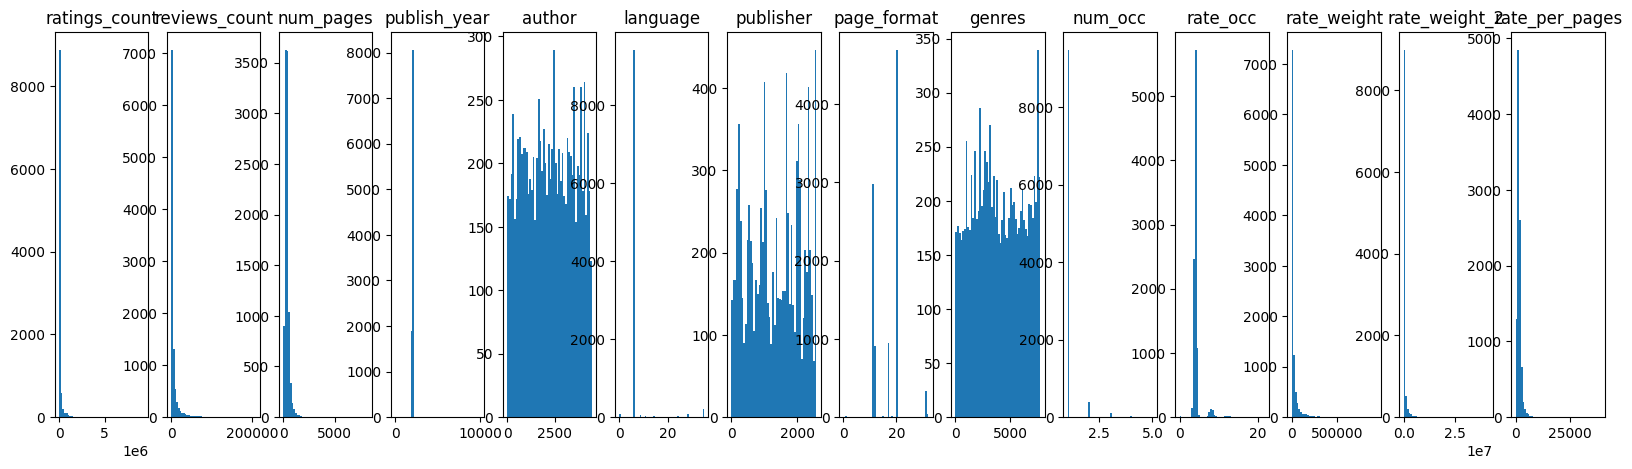

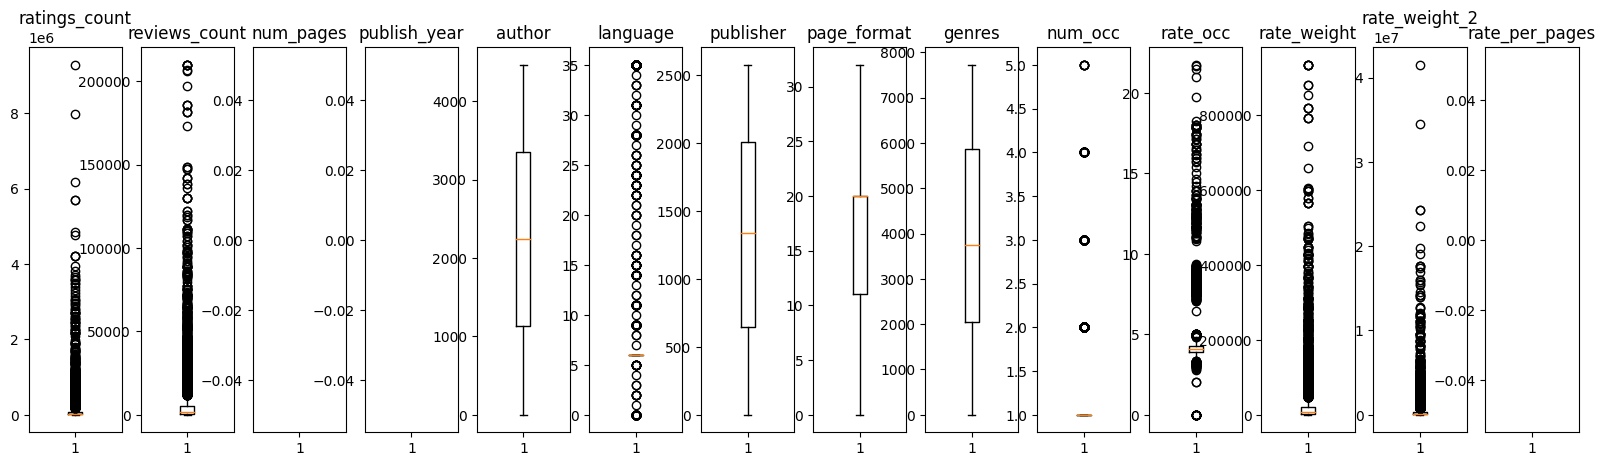

In [94]:
plotDistribution(df, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres','num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])
plotBox(df, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres','num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])

In [99]:
skewedDists = ['ratings_count', 'reviews_count', 'num_pages', 'language', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages']
isUpper_bridge = [True, True, True, True, True, True, True, True, True]
skewedDists = {col: isUpper_bridge for col, isUpper_bridge in zip(skewedDists, isUpper_bridge)}
gaussionDists = ['publish_year']
isUpper_boundary = [False]
gaussionDists = {col: isUpper_boundary for col, isUpper_boundary in zip(gaussionDists, isUpper_boundary)}

In [68]:
def outliers_handle(data, variable, isShow=False):
    upper_boundary=data[variable].mean() + 3 * data[variable].std()
    lower_boundary=data[variable].mean() - 3 * data[variable].std()
    if isShow:
        print(f"upper_boundary: {upper_boundary}")
        print(f"lower_boundary: {lower_boundary}")
        print(f"mean: {data[variable].mean()}")
    return lower_boundary, upper_boundary

def outliers_handle_skewed(data, variable, isShow=False):
    IQR=data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_bridge=data[variable].quantile(0.25) - (IQR*3)
    upper_bridge=data[variable].quantile(0.75) + (IQR*3)
    if isShow:
        print(f"lower_bridge: {lower_bridge}")
        print(f"upper_bridge: {upper_bridge}")
    return lower_bridge, upper_bridge

In [69]:
minMaxScaler = MinMaxScaler()
maxAbsScaler = MaxAbsScaler()
standardScaler = StandardScaler()
robustScaler = RobustScaler()
normalizer = Normalizer()
quantileTransformer = QuantileTransformer(n_quantiles=640)
powerTransformer = PowerTransformer()
scalerArr = [minMaxScaler, maxAbsScaler, standardScaler, robustScaler, normalizer, quantileTransformer, powerTransformer]

In [70]:
def scaleData(data_train, data_val, data_test, scaler):
    scaler.fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.copy()), columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.copy()), columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.copy()), columns=data_test.columns)
    return data_train, data_val, data_test

In [71]:
def handleOutlier(data_train, data_val, data_test):
    for col in skewedDists:
        lower_bridge, upper_bridge = outliers_handle_skewed(data_train, col)
        if skewedDists[col]:
            data_train.loc[data_train[col]>=upper_bridge,col]=upper_bridge
            data_val.loc[data_val[col]>=upper_bridge,col]=upper_bridge
            data_test.loc[data_test[col]>=upper_bridge,col]=upper_bridge
        else:
            data_train.loc[data_train[col]<=lower_bridge,col]=lower_bridge
            data_val.loc[data_val[col]<=lower_bridge,col]=lower_bridge
            data_test.loc[data_test[col]<=lower_bridge,col]=lower_bridge
        
    for col in gaussionDists:
        lower_boundary, upper_boundary = outliers_handle(data_train, col)
        if gaussionDists[col]:
            data_train.loc[data_train[col]>=upper_boundary,col]=upper_boundary
            data_val.loc[data_val[col]>=upper_boundary,col]=upper_boundary
            data_test.loc[data_test[col]>=upper_boundary,col]=upper_boundary
        else:
            data_train.loc[data_train[col]<=lower_boundary,col]=lower_boundary
            data_val.loc[data_val[col]<=lower_boundary,col]=lower_boundary
            data_test.loc[data_test[col]<=lower_boundary,col]=lower_boundary
    return data_train, data_val, data_test

In [72]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def featureSelection(X, y): 
    X_kbest = SelectKBest(f_classif, k = 5).fit(X, y)
    ix = X_kbest.get_support() 
    data = pd.DataFrame(X_kbest.transform(X), columns = X.columns.values[ix])
    # print(data.columns.values)
    return data.columns.values

In [104]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def featureSelection1(X, y):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=10, step=1)
    selector = selector.fit(X, y)
    ix = selector.get_support() 
    data = pd.DataFrame(selector.transform(X), columns = X.columns.values[ix])
    print(data.columns.values)
    return data.columns.values

In [74]:
def preprocessor(X_train, X_val, X_test):
    X_train, X_val, X_test = fillMissingData(X_train, X_val, X_test)
    X_train, X_val, X_test = handleOutlier(X_train, X_val, X_test)
    X_train, X_val, X_test = scaleData(X_train, X_val, X_test, powerTransformer)
    return X_train, X_val, X_test

In [105]:
def selectFeatures(X_train, y_train, X_val, X_test):
    featureArray = featureSelection1(X_train, y_train)
    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

In [76]:
def proccessing(file_path):
    df = pd.read_csv(file_path)

    # check for doublications
    print(f"Number of duplicated rows: {df.duplicated().any().sum()}")
    if df.duplicated().any().sum() > 0:
        df.drop_duplicates(inplace=True)

    # check for missing values
    print(f"Number of missing values: \n{df.isnull().sum()}")

    df = extracting(df)

    data = df.copy()
    y = data['avg_ratings']
    X = data.drop(['avg_ratings'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_train, X_val, X_test = preprocessor(X_train, X_val, X_test)
    X_train_SF, X_val_SF, X_test_SF = selectFeatures(X_train, y_train, X_val, X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test,X_train_SF, X_val_SF, X_test_SF

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test,X_train_SF, X_val_SF, X_test_SF  = proccessing('data_10000.csv')

# **MODEL**

Thư viện sử để sử dụng model

In [77]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
#lựa chọn siêu tham số
from sklearn.model_selection import GridSearchCV
#Metric đánh giá mô hình
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

Lấy X_train, y_train

In [ ]:
X_train_SF.head()

In [ ]:
# X_train_SF.head()

In [ ]:
X_train_rf = X_train.copy()
X_train_svm = X_train.copy()
X_train_best_rf = X_train.copy()
X_train_best_svm = X_train.copy()

# X_train_SF_rf = X_train_SF.copy()
# X_train__SF_svm = X_train_SF.copy()

In [ ]:
y_train

In [ ]:
X_test

In [ ]:
y_test

# Random Forest Model

In [ ]:
# def model(mod, X_train, y_train, X_Pre):
#     mod.fit(X_train, y_train)
#     y_pred = mod.predict(X_Pre)
#     accuracyScore(ytest,y_pred)
    



Khi chưa select đặc trưng

In [ ]:
#khởi tạo mô hình
#random_state=42
rf = RandomForestRegressor()

#chưa chọn đặc trưng
rf.fit(X_train_SF.copy(), y_train)
y_pred_rf_val = rf.predict(X_val_SF)

In [ ]:
def plot_residuals(y_test, y_pred):
  ind = list(range(1, 201))
  fig, axs = plt.subplots(1, 1, figsize=(20, 6), sharey=True)
  axs.plot(ind, y_pred[:200], label='predicted value', color='blue')
  axs.plot(ind, y_test[:200], label='true_value', color='green')
  axs.legend()
  axs.set_ylabel('Rating')
  fig.suptitle('Predicted Value - True Value')
  plt.show()

Đánh giá mô hình

Ý nghĩa các metric:
- MAE (Mean Absolute Error) : Thể hiện sự chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.
- RMSE (Root Mean Squared Error) : Thể hiện độ lệch chuẩn giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.
- R2 score (Coefficient of Determination) : Thể hiện độ giải thích của mô hình trên tổng phương sai của dữ liệu. Giá trị này càng gần 1 thì mô hình càng tốt.
- MAPE (Mean Absolute Percentage Error)  : Thể hiện tỷ lệ chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế. Giá trị này càng thấp thì mô hình càng chính xác.

In [80]:
def accuracyScore(y_test, y_pred, isShow = True):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    # adjusted_r2 = 1 - (1-r2score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    # MAPE = mean_absolute_percentage_error(y_test, y_pred)
    if isShow:
        print(
            f'MAE: \n{MAE}\n'
            f'RMSE: \n{RMSE}\n'
            f'R2 score: \n{r2score}\n'
            # f'MAPE: \n{MAPE}\n'
        )
        plt.scatter(y_test, y_pred, color='red')
        plt.xlabel('True values')
        plt.xlabel('Predicted values')
        plt.axis('equal')
        plt.axis('square')
        plt.show()
    return MAE, RMSE, r2score

In [ ]:
#chưa select
plot_residuals(y_val, y_pred_rf_val)
accuracyScore(y_val,y_pred_rf_val)

Define parameter grid for GridSearchCV

Ý nghĩa các tham số của mô hình rf
- n_estimators:  số lượng cây trong mô hình.
- max_depth:  độ sâu tối đa của các cây.
- min_samples_split:  số lượng mẫu tối thiểu để phân tách một nút.
- min_samples_leaf:  số lượng mẫu tối thiểu trong một lá cây.
- max_features:  số lượng tính năng tối đa được sử dụng để tìm kiếm trên mỗi nút.

In [ ]:
#random forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 5, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
def findBestParams(model,param_grid, X_train, y_train):
    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    # Fit GridSearchCV on Validation set
    grid_search.fit(X_train, y_train)
    return grid_search

In [ ]:
# In ra bộ siêu tham số tối ưu
# Get best estimator from GridSearchCV
rf2 = RandomForestRegressor()
best_rf = findBestParams(rf2,param_grid_rf, X_train_rf, y_train).best_params_
best_rf

In [ ]:

# Khởi tạo lại mô hình với các tham số tối ưu
rf_best_params = RandomForestRegressor(max_depth=best_rf['max_depth'], n_estimators=best_rf['n_estimators'], max_features=best_rf['max_features'], min_samples_split=best_rf['min_samples_split'], min_samples_leaf=best_rf['min_samples_leaf'], random_state=42 )

rf_best_params.fit(X_train_rf, y_train)

# Sử dụng mô hình đã huấn luyện để dự đoán trên tập Val set
y_pred_best_rf = rf_best_params.predict(X_val)

accuracyScore(y_val, y_pred_best_rf)
plot_residuals(y_val, y_pred_best_rf)

In [ ]:
#Tập test
y_predTestRF = rf_best_params.predict(X_test)

accuracyScore(y_test, y_predTestRF)
plot_residuals(y_test, y_predTestRF)

# SVM MODEL

In [ ]:
# Khởi tạo mô hình SVM
svr = SVR()
svr.fit(X_train_svm, y_train)
y_pred_svr_val = rf.predict(X_val)

In [ ]:
plot_residuals(y_val, y_pred_svr_val)
accuracyScore(y_val,y_pred_svr_val)

In [ ]:
# Định nghĩa các tham số cần tinh chỉnh
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

In [ ]:
# In ra bộ siêu tham số tối ưu
# Get best estimator from GridSearchCV
svr2 = SVR()
best_svr = findBestParams(svr2,param_grid_svr, X_train_best_svm, y_train).best_params_
best_svr

In [ ]:
# Khởi tạo lại mô hình với các tham số tối ưu

svr_best_params = SVR(kernel=best_svr['kernel'], C=10, gamma=best_svr['gamma'], epsilon=0.1)

svr_best_params.fit(X_train_best_svm, y_train)

# Sử dụng mô hình đã huấn luyện để dự đoán trên tập Val set
y_pred_best_svr = svr_best_params.predict(X_val)

accuracyScore(y_val, y_pred_best_svr)
plot_residuals(y_val, y_pred_best_svr)

In [ ]:
#Tập test
y_predTest = svr_best_params.predict(X_test)

accuracyScore(y_test, y_predTest)
plot_residuals(y_test, y_predTest)

In [97]:
def trainModel(X_train, y_train, X_val, y_val):
    result = []
    label = ['Random Forest', 'SVR']
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    MAE, RMSE, r2score = accuracyScore(y_val, y_pred, False)
    result.append([MAE, RMSE, r2score])
    
    model = SVR()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    MAE, RMSE, r2score = accuracyScore(y_val, y_pred, False)
    result.append([MAE, RMSE, r2score])
    result = pd.DataFrame(result, columns=['MAE', 'RMSE', 'r2score'], index=label)
    return result    

In [82]:
# check for doublications
print(f"Number of duplicated rows: {df.duplicated().any().sum()}")
if df.duplicated().any().sum() > 0:
    df.drop_duplicates(inplace=True)

Number of duplicated rows: 1


In [83]:
# check for missing values
print(f"Number of missing values: \n{df.isnull().sum()}")

Number of missing values: 
title              0
author             0
language         211
avg_ratings        0
ratings_count      0
reviews_count      0
publisher        372
publish_year      61
num_pages        124
page_format       44
genres             0
link               0
dtype: int64


In [84]:
df['num_occ'] = df.groupby('title')['title'].transform('count')
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,link,num_occ
0,The Hunger Games,Suzanne Collins,English,4.33,"7,971,601","196,977",Scholastic Press,2008.0,374.0,Hardcover,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",https://www.goodreads.com/book/show/2767052-th...,1
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,English,4.50,"3,150,618","57,202",Scholastic Inc.,2004.0,912.0,Paperback,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",https://www.goodreads.com/book/show/2.Harry_Po...,2
2,Pride and Prejudice,Jane Austen,English,4.28,"3,948,185","100,606",Modern Library,2000.0,279.0,Paperback,"['Classics', 'Fiction', 'Romance', 'Historical...",https://www.goodreads.com/book/show/1885.Pride...,1
3,To Kill a Mockingbird,Harper Lee,English,4.27,"5,696,477","110,338",Harper Perennial Modern Classics,2006.0,323.0,Paperback,"['Classics', 'Fiction', 'Historical Fiction', ...",https://www.goodreads.com/book/show/2657.To_Ki...,2
4,The Book Thief,Markus Zusak,English,4.39,"2,367,106","136,148",Alfred A. Knopf,2006.0,552.0,Hardcover,"['Historical Fiction', 'Fiction', 'Young Adult...",https://www.goodreads.com/book/show/19063.The_...,1


In [85]:
df = extracting(df)
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,num_occ
0,The Hunger Games,3991,6,4.33,7971601,196977,1966,2008.0,374.0,11,3177,1
1,Harry Potter and the Order of the Phoenix,1679,6,4.50,3150618,57202,1964,2004.0,912.0,20,3049,2
2,Pride and Prejudice,1788,6,4.28,3948185,100606,1474,2000.0,279.0,20,2141,1
3,To Kill a Mockingbird,1517,6,4.27,5696477,110338,990,2006.0,323.0,20,6554,2
4,The Book Thief,2822,6,4.39,2367106,136148,72,2006.0,552.0,11,5746,1


In [86]:
df['rate_occ'] = df['avg_ratings'] * df['num_occ']
df['rate_weight'] = df['avg_ratings'] * df['reviews_count']
df['rate_weight_2'] = df['avg_ratings'] * df['ratings_count']
df['rate_per_pages'] = df['avg_ratings'] * df['num_pages']
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,num_occ,rate_occ,rate_weight,rate_weight_2,rate_per_pages
0,The Hunger Games,3991,6,4.33,7971601,196977,1966,2008.0,374.0,11,3177,1,4.33,852910.41,34517032.33,1619.42
1,Harry Potter and the Order of the Phoenix,1679,6,4.50,3150618,57202,1964,2004.0,912.0,20,3049,2,9.00,257409.00,14177781.00,4104.00
2,Pride and Prejudice,1788,6,4.28,3948185,100606,1474,2000.0,279.0,20,2141,1,4.28,430593.68,16898231.80,1194.12
3,To Kill a Mockingbird,1517,6,4.27,5696477,110338,990,2006.0,323.0,20,6554,2,8.54,471143.26,24323956.79,1379.21
4,The Book Thief,2822,6,4.39,2367106,136148,72,2006.0,552.0,11,5746,1,4.39,597689.72,10391595.34,2423.28


In [87]:
df.drop(['title'], axis=1, inplace=True)

data = df.copy()
y = data['avg_ratings']
X = data.drop(['avg_ratings'], axis=1)

In [89]:
df.isnull().sum()

author              0
language            0
avg_ratings         0
ratings_count       0
reviews_count       0
publisher           0
publish_year       61
num_pages         124
page_format         0
genres              0
num_occ             0
rate_occ            0
rate_weight         0
rate_weight_2       0
rate_per_pages    124
dtype: int64

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [98]:
X_train, X_val, X_test = fillMissingData(X_train, X_val, X_test)
result = trainModel(X_train, y_train, X_val, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.003580,0.051926,0.974739
SVR,0.180056,0.304854,0.129303


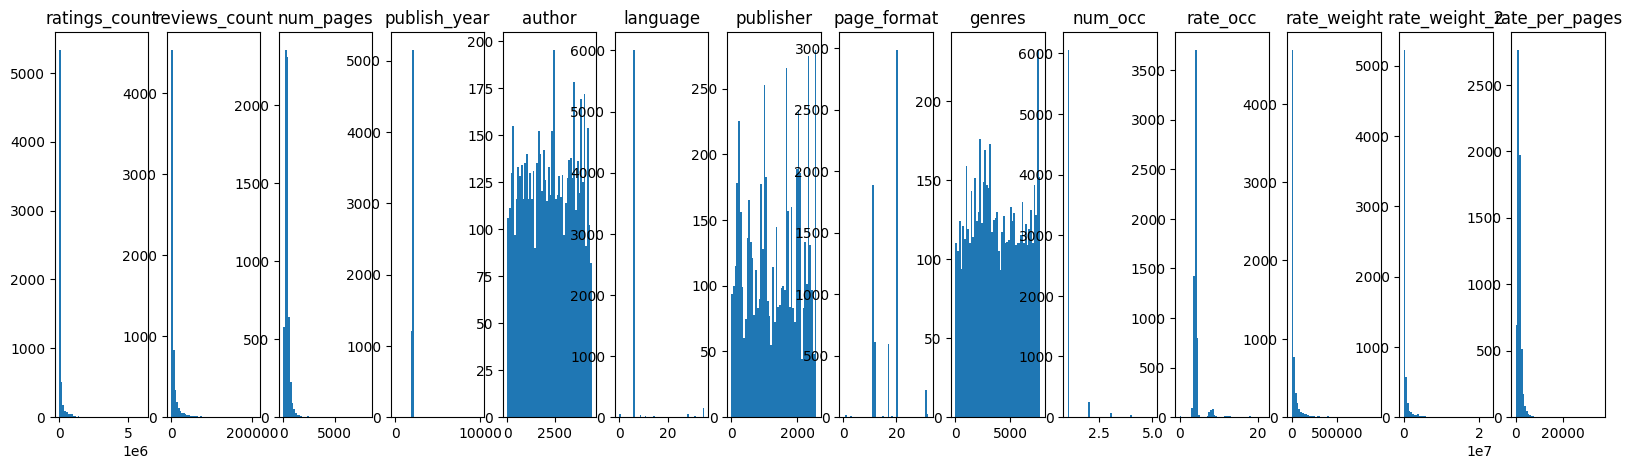

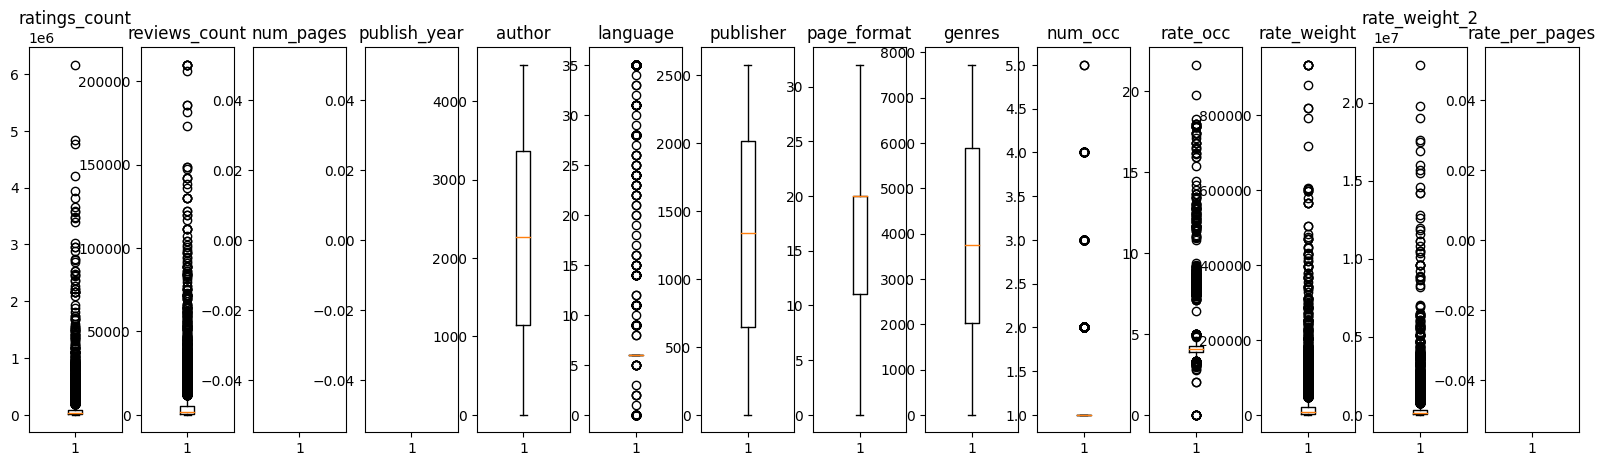

In [95]:
plotDistribution(X_train, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])
plotBox(X_train, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])

In [100]:
X_train, X_val, X_test = handleOutlier(X_train, X_val, X_test)
result = trainModel(X_train, y_train, X_val, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.008212,0.060768,0.965403
SVR,0.146736,0.284701,0.240618


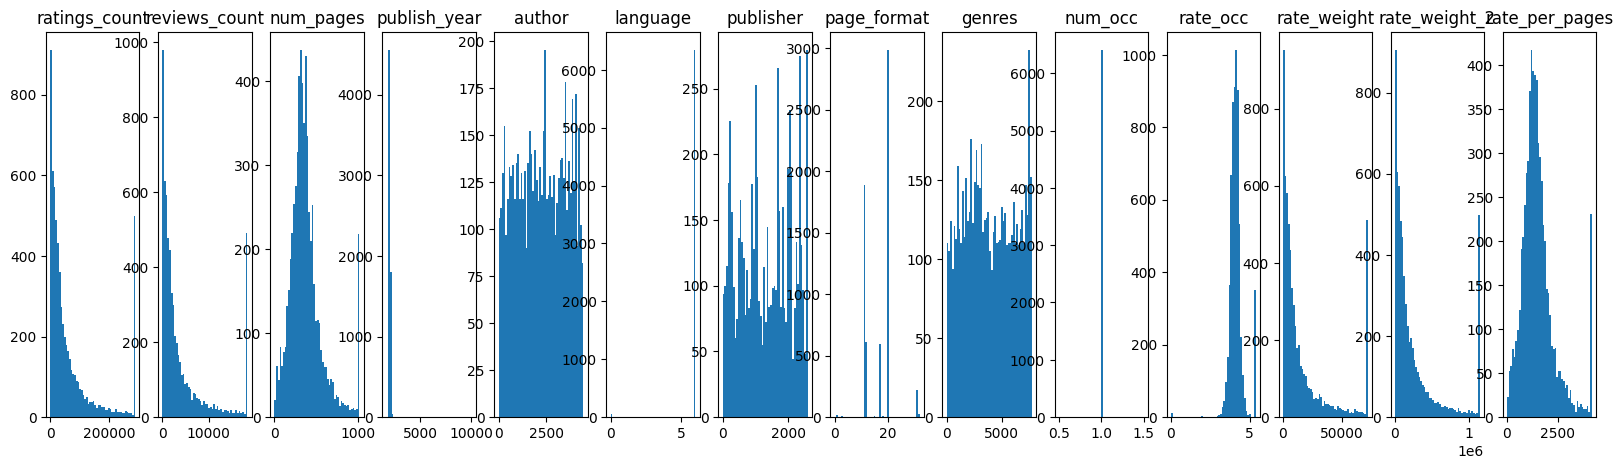

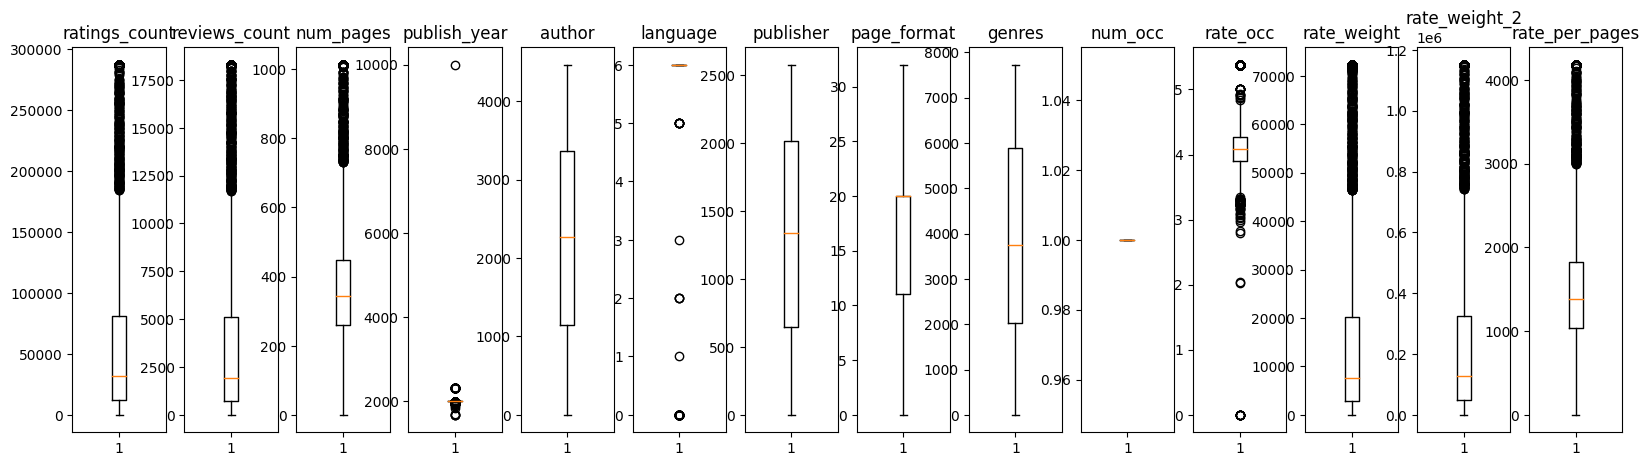

In [101]:
plotDistribution(X_train, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])
plotBox(X_train, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])

In [102]:
X_train, X_val, X_test = scaleData(X_train, X_val, X_test, powerTransformer)
result = trainModel(X_train, y_train, X_val, y_val)
result

,MAE,RMSE,r2score
Random Forest,0.007867,0.059810,0.966486
SVR,0.051477,0.109521,0.887622


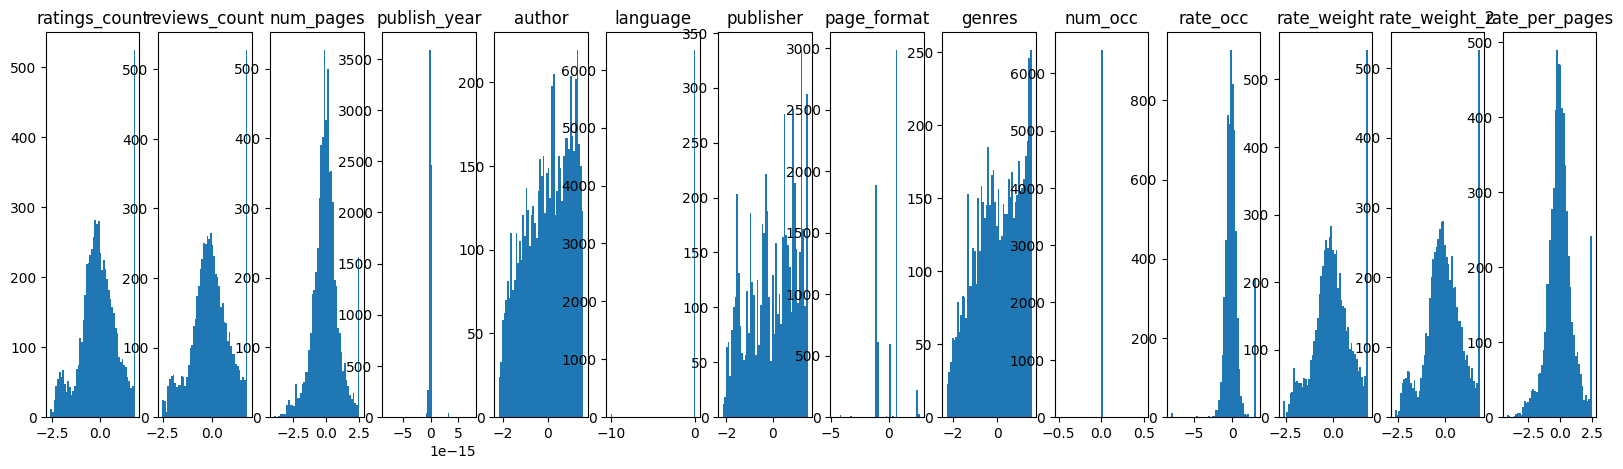

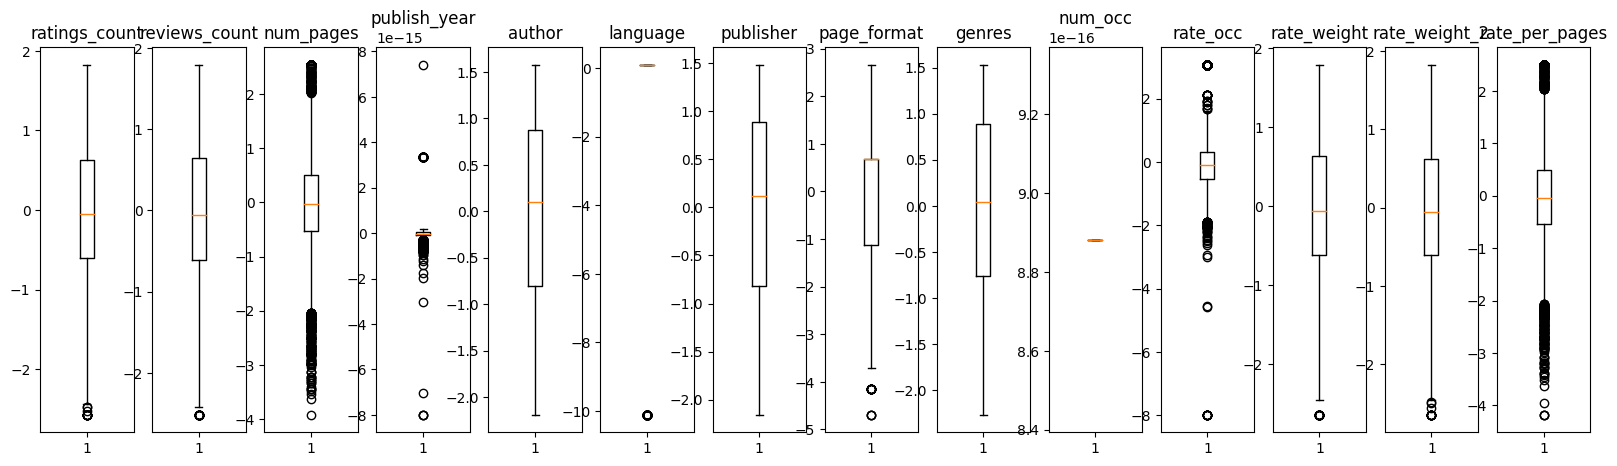

In [103]:
plotDistribution(X_train, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])
plotBox(X_train, ['ratings_count', 'reviews_count', 'num_pages', 'publish_year', 'author', 'language', 'publisher', 'page_format', 'genres', 'num_occ', 'rate_occ', 'rate_weight', 'rate_weight_2', 'rate_per_pages'])

In [106]:
X_train_SF, X_val_SF, X_test_SF = selectFeatures(X_train, y_train, X_val, X_test)
result = trainModel(X_train, y_train, X_val, y_val)
result

['author' 'language' 'ratings_count' 'reviews_count' 'num_pages'
 'page_format' 'rate_occ' 'rate_weight' 'rate_weight_2' 'rate_per_pages']


,MAE,RMSE,r2score
Random Forest,0.007743,0.056001,0.970619
SVR,0.051477,0.109521,0.887622
